In [1]:
import torch
import copy, math, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from transformers import LlamaForCausalLM, LlamaTokenizer
LAYER_NUM = 32
HEAD_NUM = 32
HEAD_DIM = 128
HIDDEN_DIM = HEAD_NUM * HEAD_DIM
torch.set_default_device("cuda")
zero_tensor = torch.tensor([0.0]*4096)

In [2]:
def get_fc2_params(model, layer_num):
    return model.model.layers[layer_num].mlp.down_proj.weight.data
def transfer_output(model_output):
    all_pos_layer_input = []
    all_pos_attn_output = []
    all_pos_residual_output = []
    all_pos_ffn_output = []
    all_pos_layer_output = []
    all_last_attn_subvalues = []
    all_pos_coefficient_scores = []
    all_attn_scores = []
    for layer_i in range(LAYER_NUM):
        cur_layer_input = model_output[layer_i][0]
        cur_attn_output = model_output[layer_i][1]
        cur_residual_output = model_output[layer_i][2]
        cur_ffn_output = model_output[layer_i][3]
        cur_layer_output = model_output[layer_i][4]
        cur_last_attn_subvalues = model_output[layer_i][5]
        cur_coefficient_scores = model_output[layer_i][6]
        cur_attn_weights = model_output[layer_i][7]
        all_pos_layer_input.append(cur_layer_input[0].tolist())
        all_pos_attn_output.append(cur_attn_output[0].tolist())
        all_pos_residual_output.append(cur_residual_output[0].tolist())
        all_pos_ffn_output.append(cur_ffn_output[0].tolist())
        all_pos_layer_output.append(cur_layer_output[0].tolist())
        all_last_attn_subvalues.append(cur_last_attn_subvalues[0].tolist())
        all_pos_coefficient_scores.append(cur_coefficient_scores[0].tolist())
        all_attn_scores.append(cur_attn_weights)
    return all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, \
           all_pos_layer_output, all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores
def get_bsvalues(vector, model, final_var):
    vector = vector * torch.rsqrt(final_var + 1e-6)
    vector_rmsn = vector * model.model.norm.weight.data
    vector_bsvalues = model.lm_head(vector_rmsn).data
    return vector_bsvalues
def get_prob(vector):
    prob = torch.nn.Softmax(-1)(vector)
    return prob
def get_log_increase(model, all_ffn_subvalues, all_pos_residual_output, final_var, predict_index):
    all_ffn_log_increase = []
    for layer_i in range(LAYER_NUM):
        cur_ffn_subvalues = all_ffn_subvalues[layer_i]
        cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
        origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
        cur_ffn_subvalues_plus = cur_ffn_subvalues + cur_residual
        cur_ffn_subvalues_bsvalues = get_bsvalues(cur_ffn_subvalues_plus, model, final_var)
        cur_ffn_subvalues_probs = get_prob(cur_ffn_subvalues_bsvalues)
        cur_ffn_subvalues_probs = cur_ffn_subvalues_probs[:, predict_index]
        cur_ffn_subvalues_probs_log = torch.log(cur_ffn_subvalues_probs)
        cur_ffn_subvalues_probs_log_increase = cur_ffn_subvalues_probs_log - origin_prob_log
        all_ffn_log_increase.append(cur_ffn_subvalues_probs_log_increase.tolist())
    return all_ffn_log_increase
def plt_bar(x, y, yname="log increase"):
    x_major_locator=MultipleLocator(1)
    plt.figure(figsize=(8, 3))
    ax=plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    plt_x = [a/2 for a in x]
    plt.xlim(-0.5, plt_x[-1]+0.49)
    x_attn, y_attn, x_ffn, y_ffn = [], [], [], []
    for i in range(len(x)):
        if i%2 == 0:
            x_attn.append(x[i]/2)
            y_attn.append(y[i])
        else:
            x_ffn.append(x[i]/2)
            y_ffn.append(y[i])
    plt.bar(x_attn, y_attn, color="darksalmon", label="attention layers")
    plt.bar(x_ffn, y_ffn, color="lightseagreen", label="FFN layers")
    plt.xlabel("layer")
    plt.ylabel(yname)
    plt.legend()
    plt.show()

In [3]:
#please replace your own dir saving llama-7b model.
#if you haven't downloaded it, you can try "huggyllama/llama-7b" to automatically download it from huggingface.
modelname = "../../scratch/save_models/llama-7b" 
tokenizer = LlamaTokenizer.from_pretrained(modelname)
model = LlamaForCausalLM.from_pretrained(modelname)
model.eval()
model.cuda()

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
 

In [4]:
#compute the final prediction of the input
test_sentence = "3+5="
indexed_tokens = tokenizer.encode(test_sentence)
tokens = [tokenizer.decode(x) for x in indexed_tokens]
tokens_tensor = torch.tensor([indexed_tokens])
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]
predicted_top10 = torch.argsort(predictions[0][-1], descending=True)[:10]
predicted_text = [tokenizer.decode(x) for x in predicted_top10]
print(test_sentence, "=>", predicted_text)
all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, all_pos_layer_output, \
all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores = transfer_output(outputs[1])
final_var = torch.tensor(all_pos_layer_output[-1][-1]).pow(2).mean(-1, keepdim=True)
pos_len = len(tokens)
print(tokens)

3+5= => ['8', '1', '6', '7', '2', '?', '', '3', '4', '5']
['<s>', '', '3', '+', '5', '=']


In [5]:
predict_index = predicted_top10[0].item()
print(predict_index, tokenizer.decode(predict_index))
cur_prob = get_prob(predictions[0][-1])[predict_index].item()
print("prob: ", cur_prob)
all_head_dict_prob, all_head_dict_logprob = {}, {}
all_head_dict_prob["old"] = cur_prob
all_head_dict_logprob["old"] = math.log(cur_prob)

29947 8
prob:  0.3775949776172638


In [6]:
#identifying the important heads
all_attn_o_weights = []
for layer_index in range(LAYER_NUM):
    all_attn_o_weights.append(model.model.layers[layer_index].self_attn.o_proj.weight.data)
t1 = time.time()
for layer_index in range(LAYER_NUM):
    for head_index in range(HEAD_NUM):
        model1 = copy.deepcopy(model)
        all_attn_o_weights_new = copy.deepcopy(all_attn_o_weights[layer_index])
        start, end = HEAD_DIM*head_index, HEAD_DIM*head_index+HEAD_DIM
        for neuron_index in range(start, end):
            all_attn_o_weights_new[:, neuron_index] = zero_tensor
        new_parameters = torch.nn.Parameter(all_attn_o_weights_new)
        model1.model.layers[layer_index].self_attn.o_proj.weight = new_parameters
        del all_attn_o_weights_new
        with torch.no_grad():
            outputs1 = model1(tokens_tensor)
            predictions1 = outputs1[0]
        cur_prob1 = get_prob(predictions1[0][-1])[predict_index].item()
        all_head_dict_prob[str(layer_index)+"_"+str(head_index)] = cur_prob1
        all_head_dict_logprob[str(layer_index)+"_"+str(head_index)] = math.log(cur_prob1)
        del model1
t2 = time.time()
print("time: ", t2-t1)

time:  89.6403636932373


In [7]:
all_head_dict_prob_list = list(zip(all_head_dict_prob.keys(), all_head_dict_prob.values()))
all_head_dict_prob_list_sort = sorted(all_head_dict_prob_list, key=lambda x:x[1])
print("prob: ", all_head_dict_prob_list_sort[:10])
all_head_dict_logprob_list = list(zip(all_head_dict_logprob.keys(), all_head_dict_logprob.values()))
all_head_dict_logprob_list_sort = sorted(all_head_dict_logprob_list, key=lambda x:x[1])
print("logprob: ", all_head_dict_logprob_list_sort[:10])

prob:  [('17_22', 0.06159592792391777), ('13_15', 0.15388499200344086), ('14_19', 0.2144710272550583), ('15_9', 0.2402653694152832), ('1_8', 0.24745655059814453), ('6_20', 0.26361238956451416), ('12_16', 0.28505939245224), ('0_18', 0.29116934537887573), ('2_16', 0.29402652382850647), ('13_2', 0.29580187797546387)]
logprob:  [('17_22', -2.7871595157589084), ('13_15', -1.871549760738866), ('14_19', -1.5395806208089735), ('15_9', -1.4260112605856645), ('1_8', -1.396520265523458), ('6_20', -1.3332754760754846), ('12_16', -1.2550577258553555), ('0_18', -1.233850238191005), ('2_16', -1.22408529860901), ('13_2', -1.2180653799241583)]


attn sum:  1.7839999999999996 ffn sum:  7.618
attn:  [('30', 0.475), ('26', 0.262), ('31', 0.209), ('13', 0.193), ('29', 0.174), ('21', 0.143), ('17', 0.093), ('28', 0.093), ('27', 0.063), ('25', 0.061), ('11', 0.055), ('24', 0.049), ('8', 0.045), ('22', 0.04), ('12', 0.023), ('10', 0.014), ('19', 0.012), ('2', 0.012), ('1', 0.01), ('0', 0.008), ('20', 0.007), ('4', 0.006), ('9', 0.005), ('5', -0.001), ('7', -0.002), ('3', -0.004), ('23', -0.01), ('18', -0.019), ('6', -0.029), ('14', -0.06), ('15', -0.068), ('16', -0.075)]
ffn:  [('28', 1.659), ('30', 1.207), ('29', 1.151), ('31', 0.78), ('25', 0.682), ('27', 0.582), ('23', 0.538), ('20', 0.281), ('19', 0.23), ('26', 0.22), ('16', 0.207), ('9', 0.038), ('3', 0.034), ('13', 0.032), ('5', 0.025), ('15', 0.023), ('12', 0.021), ('7', 0.02), ('2', 0.019), ('17', 0.017), ('1', 0.016), ('0', 0.015), ('4', 0.008), ('21', 0.004), ('6', 0.003), ('11', -0.002), ('10', -0.007), ('24', -0.011), ('14', -0.02), ('22', -0.025), ('8', -0.025), ('18', -

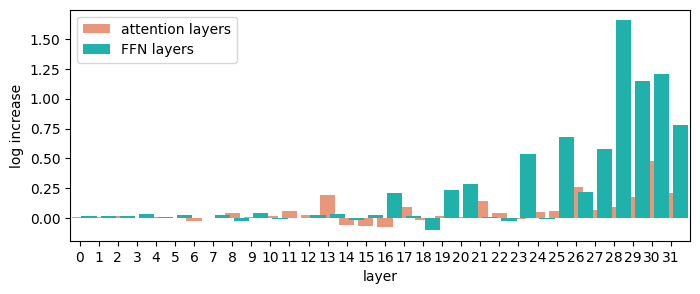

In [8]:
#layer-level increase: most increase happens in deep FFN layers
#please see this paper for details: https://arxiv.org/pdf/2312.12141
all_attn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_attn_vector = torch.tensor(all_pos_attn_output[layer_i][-1])
    cur_layer_input = torch.tensor(all_pos_layer_input[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_layer_input, model, final_var))[predict_index])
    cur_attn_vector_plus = cur_attn_vector + cur_layer_input
    cur_attn_vector_bsvalues = get_bsvalues(cur_attn_vector_plus, model, final_var)
    cur_attn_vector_probs = get_prob(cur_attn_vector_bsvalues)
    cur_attn_vector_probs = cur_attn_vector_probs[predict_index]
    cur_attn_vector_probs_log = torch.log(cur_attn_vector_probs)
    cur_attn_vector_probs_log_increase = cur_attn_vector_probs_log - origin_prob_log
    all_attn_log_increase.append(cur_attn_vector_probs_log_increase.item())
all_ffn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_ffn_vector = torch.tensor(all_pos_ffn_output[layer_i][-1])
    cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
    cur_ffn_vector_plus = cur_ffn_vector + cur_residual
    cur_ffn_vector_bsvalues = get_bsvalues(cur_ffn_vector_plus, model, final_var)
    cur_ffn_vector_probs = get_prob(cur_ffn_vector_bsvalues)
    cur_ffn_vector_probs = cur_ffn_vector_probs[predict_index]
    cur_ffn_vector_probs_log = torch.log(cur_ffn_vector_probs)
    cur_ffn_vector_probs_log_increase = cur_ffn_vector_probs_log - origin_prob_log
    all_ffn_log_increase.append(cur_ffn_vector_probs_log_increase.tolist())
attn_list, ffn_list = [], []
for layer_i in range(LAYER_NUM):
    attn_list.append([str(layer_i), all_attn_log_increase[layer_i]])
    ffn_list.append([str(layer_i), all_ffn_log_increase[layer_i]])
attn_list_sort = sorted(attn_list, key=lambda x: x[-1])[::-1]#[:10]
ffn_list_sort = sorted(ffn_list, key=lambda x: x[-1])[::-1]#[:10]
attn_increase_compute, ffn_increase_compute = [], []
for indx, increase in attn_list_sort:
    attn_increase_compute.append((indx, round(increase, 3)))
for indx, increase in ffn_list_sort:
    ffn_increase_compute.append((indx, round(increase, 3)))
print("attn sum: ", sum([x[1] for x in attn_increase_compute]), 
      "ffn sum: ", sum([x[1] for x in ffn_increase_compute]))
print("attn: ", attn_increase_compute)
print("ffn: ", ffn_increase_compute)
all_increases_draw = []
for i in range(len(attn_list)):
    all_increases_draw.append(attn_list[i][1])
    all_increases_draw.append(ffn_list[i][1])    
plt_bar(range(len(all_increases_draw)), all_increases_draw)